In [2]:
from typing import Dict, Callable
from ensmallen_graph import EnsmallenGraph
from ensmallen_experiments import MeasureResources
import compress_json
from tqdm.auto import tqdm, trange
import os
from time import perf_counter, sleep
from humanize import naturaldelta
import matplotlib.pyplot as plt
import pandas as pd
from sanitize_ml_labels import sanitize_ml_labels
import networkx as nx
from glob import glob
from node2vec import Node2Vec
from multiprocessing import cpu_count
from barplots import barplots
from IPython.display import Image, display
import shutil
import csrgraph as cg
import gc
from cache_decorator import Cache

## Method to load the graphs using each library

In [2]:
def load_graph_ensmallen(edge_path:str, nodes_number:int, edges_number:int)->EnsmallenGraph:
    """Load graph object using EnsmallenGraph."""
    return EnsmallenGraph.from_sorted_csv(
        edge_path,
        directed=False,
        nodes_number=nodes_number,
        edges_number=edges_number,
        sources_column_number=0,
        destinations_column_number=1,
        numeric_node_ids=True,
        verbose=False,
        edge_header=False
    )

In [3]:
def load_graph_networkx(edge_path:str, *args, **kwargs) -> nx.Graph:
    """Load graph object using NetworkX."""
    return nx.read_edgelist(
        edge_path,
        data=False,
        delimiter="\t",
    )

In [4]:
def load_graph_csrgraph(edge_path:str, *args, **kwargs) -> cg.csrgraph:
    """Load graph object using CSRgraph."""
    return cg.read_edgelist(
        edge_path,
        sep="\t",
    )

## Methods to compute first and second order walks in each library

In [5]:
def ensmallen_first_order_walks(graph: EnsmallenGraph, walk_length:int, num_walks:int, **kwargs):
    """Execute uniform first order walks using Networkx-based node2vec walker."""
    return graph.complete_walks(length=walk_length, iterations=num_walks)

def ensmallen_second_order_walks(graph: EnsmallenGraph, p:float, q:float, walk_length:int, num_walks:int):
    """Execute uniform second order walks using Networkx-based node2vec walker."""
    return graph.complete_walks(length=walk_length, iterations=num_walks, return_weight=1/p, explore_weight=1/q)

In [6]:
def node2vec_first_order_walks(graph: nx.Graph, walk_length:int, num_walks:int, **kwargs):
    """Execute uniform first order walks using Networkx-based node2vec walker."""
    return Node2Vec(graph, quiet=True, walk_length=walk_length, num_walks=num_walks, workers=cpu_count()).walks

def node2vec_second_order_walks(graph: nx.Graph, p:float, q:float, walk_length:int, num_walks:int):
    """Execute uniform second order walks using Networkx-based node2vec walker."""
    return Node2Vec(graph, quiet=True, walk_length=walk_length, num_walks=num_walks, workers=cpu_count(), p=p, q=q).walks

In [7]:
def csrgraph_first_order_walks(graph: cg.csrgraph, walk_length:int, num_walks:int, **kwargs):
    """Execute uniform first order walks using CSRgraph-based node2vec walker."""
    return graph.random_walks(walklen=walk_length, epochs=num_walks)

def csrgraph_second_order_walks(graph: nx.Graph, p:float, q:float, walk_length:int, num_walks:int):
    """Execute uniform second order walks using CSRgraph-based node2vec walker."""
    return graph.random_walks(walklen=walk_length, epochs=num_walks, return_weight=1/p, neighbor_weight=1/q)

In [8]:
def build_directed_path(data:Dict, root:str):
    """Build path to edge file from given metadata."""
    return os.path.join(root, data["folder_name"], "directed_sanitized.tsv")

def build_undirected_path(data:Dict, root:str):
    """Build path to edge file from given metadata."""
    return os.path.join(root, data["folder_name"], "undirected_sanitized.tsv")

def get_graph_report(data:Dict, root:str)->Dict:
    """Build path to edge file from given metadata."""
    return compress_json.load(os.path.join(root, data["folder_name"], "report.json"))

## The parameters for the experiments

In [9]:
graph_root = "graphs"
walk_parameters = dict(
    walk_length=100,
    num_walks=1, # This is the iterations parameter in ensmallen.
    p=2,
    q=2
)

libraries_methods = {
    "ensmallen":[
        load_graph_ensmallen,
        ensmallen_first_order_walks,
        ensmallen_second_order_walks,
        build_directed_path
    ],
    "networkx":[
        load_graph_networkx,
        node2vec_first_order_walks,
        node2vec_second_order_walks,
        build_directed_path
    ],
    "csrgrph":[
        load_graph_csrgraph,
        csrgraph_first_order_walks,
        csrgraph_second_order_walks,
        build_undirected_path
    ]
}

## Execute the benchmarks

In [10]:
@Cache(   
    cache_path = 'results/{library}_{name}.pkl',
    verbose=True
)
def run_benchmark(
    nodes_number:int,
    edges_number:int,
    library:str,
    name:str,
    walk_parameters:Dict,
    path:str,
    builder:Callable,
    first_order_walker:Callable,
    second_order_walker:Callable
):
    gc.disable()
    tracker = MeasureResources(verbose=False)
    results = {}
    with tracker():
        graph = builder(path, nodes_number, edges_number)
    results["builder"] = tracker.get_results()
    walks = None
    with tracker():
        walks = first_order_walker(graph, **walk_parameters)
    del walks
    results["first_order_walks"] = tracker.get_results()
    for i in range(10):
        sleep(1)
        gc.collect()
    walks = None
    with tracker():
        walks = second_order_walker(graph, **walk_parameters)
    del walks
    results["second_order_walks"] = tracker.get_results()
    for i in range(10):
        sleep(1)
        gc.collect()
    return results

In [11]:
graphs_data = compress_json.load("graphs.json")
graphs_data = [graphs_data[0]]

graphs_results = {}

for graph_data in tqdm(graphs_data, desc="Computing graph benchmarks"):
    name = graph_data["graph"]
    report = get_graph_report(graph_data, graph_root)
    graphs_results[name] = {
        library: {
            "report": report,
            "tasks": run_benchmark(
                int(report["nodes_number"]),
                int(report["edges_number"])*2,
                library,
                name,
                walk_parameters,
                build_path(graph_data, graph_root),
                builder,
                first_order_walker,
                second_order_walker
            )
        }
        for library, (builder, first_order_walker, second_order_walker, build_path) in tqdm(
            libraries_methods.items(),
            desc="Libraries on graph {}".format(name),
            leave=False
        )
    }

/home/lucacappelletti/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


## Visualize the results

### Plot RAM over time for each task and each graph

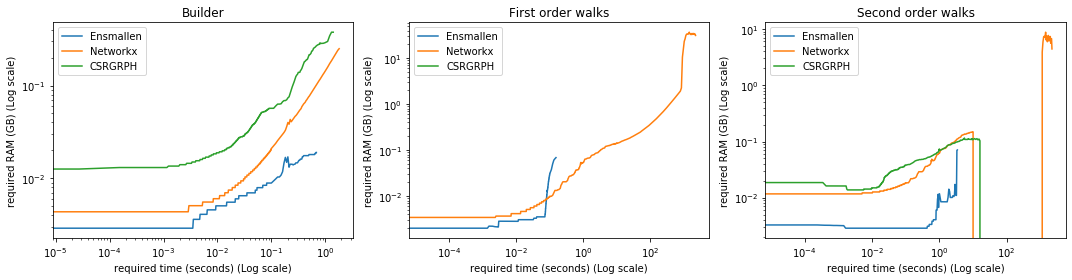

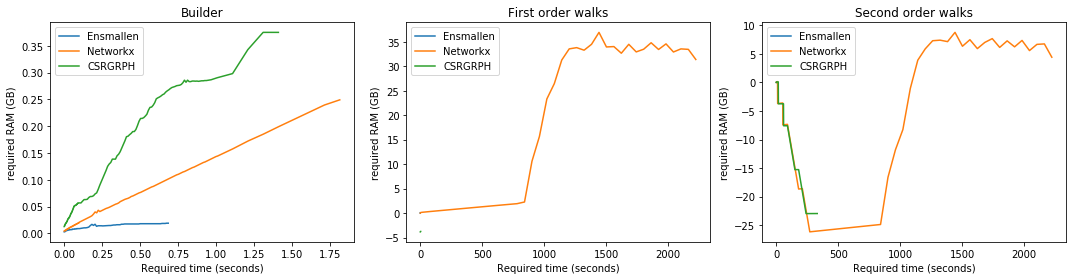

In [12]:
tasks_names = ["builder", "first_order_walks", "second_order_walks"]

for log in (True, False):
    fig, axes = plt.subplots(
        ncols=len(tasks_names),
        nrows=len(graphs_results),
        squeeze=False,
        figsize=(5*len(tasks_names), 4*len(graphs_results))
    )

    for (graph, libraries), sub_axes in zip(graphs_results.items(), axes):
        for (library, data) in libraries.items():
            for (task, logged), axis in zip(data["tasks"].items(), sub_axes):
                axis.plot(*logged.T, label=sanitize_ml_labels(library))
                axis.set_xlabel(sanitize_ml_labels(
                    "required_time (seconds){}".format(
                        " (Log scale)" if log else ""
                    )
                ))
                axis.set_ylabel(sanitize_ml_labels(
                    "required_ram (GB){}".format(
                        " (Log scale)" if log else ""
                    )
                ))
                axis.legend()
                axis.set_title(sanitize_ml_labels(task))
                if log:
                    axis.set_yscale('log')
                    axis.set_xscale('log')
    fig.tight_layout()
    fig.savefig('{}_comparison.jpg'.format("log" if log else "linear"))